In [1]:
in_path = '../data/raw/Data OA/'
out_path = '../data/interim/OA_master.pkl'

In [2]:
from os.path import dirname
import os, sys, inspect

currentdir = os.getcwd()
parentdir = dirname(currentdir)

sys.path.insert(0,parentdir)

# Libs

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import pickle

from src.utils import dump_to_pickle

# Import Tables

##### Form Admission

In [4]:
form_raw = pd.read_excel(in_path+'Form Admission.xls',
                         usecols=[2,3,11],
                         converters={'form_number':str})

In [5]:
#take rows contain form_number only 
form_master = form_raw[form_raw['form_number'].notnull()]

##### Student

In [6]:
student_raw = pd.read_excel(in_path+'Student.xls',
                              usecols=[0,7,15,18])

In [7]:
#rename column
student_master = student_raw.rename(columns={
    'id': 'student_id',
    'high_school_id': 'school_id'
})

##### Major

In [8]:
major_raw = pd.read_excel(in_path+'Major.xls',
                         usecols=[0,1,7],
                         converters={'major_code':str})

In [9]:
#rename column
major_master = major_raw.rename(columns={
    'id': 'major_id',
    'major_code': 'major_code_oa',
    'name': 'major_name_oa'
})

##### Gender

In [10]:
gender_raw = pd.read_excel(in_path+'Gender.xls',
                          usecols=[1,3,4])

In [11]:
gender_master = gender_raw.rename(columns={
    'name': 'gender'
})

In [12]:
gender_master = gender_master[gender_master['language_code']=='en']
gender_master.drop('language_code', axis=1, inplace=True)

##### School

In [13]:
school_raw = pd.read_excel(in_path+'School Master.xls',
                          usecols=[0,4,10,13])

In [14]:
school_master = school_raw.rename(columns={
    'id': 'school_id',
    'STATE': 'school_state',
    'PROPRIETORSHIP': 'school_prop',
    'DESCR': 'school_name'
})

##### Curriculum

In [15]:
curriculum_raw = pd.read_excel(in_path+'Curriculum.xls',
                              usecols=[0,3])

In [16]:
curriculum_master = curriculum_raw.rename(columns={
    'id': 'curriculum_id',
    'name': 'curriculum_name'
})

# Merge Tables

In [17]:
#merge Form with Student
OA_master = form_master.merge(student_master, how='left', on='student_id')
OA_master.drop('student_id', axis=1, inplace=True)

In [18]:
#merge with Major
OA_master = OA_master.merge(major_master, how='left', on='major_id')
OA_master.drop('major_id', axis=1, inplace=True)

In [19]:
#merge with Gender
OA_master = OA_master.merge(gender_master, how='left', on='gender_id')
OA_master.drop('gender_id', axis=1, inplace=True)

In [20]:
#merge with School
OA_master = OA_master.merge(school_master, how='left', on='school_id')
OA_master.drop('school_id', axis=1, inplace=True)

In [21]:
#merge with Curriculum
OA_master = OA_master.merge(curriculum_master, how='left', on='curriculum_id')
OA_master.drop('curriculum_id', axis=1, inplace=True)

In [22]:
OA_master.head()

,form_number,major_code_oa,major_name_oa,gender,school_state,school_prop,school_name,curriculum_name
0,1811200001,01011,Manajemen,Female,SUMUT,SMA,SMA Negeri 1 Silima Pungga,Other
1,1811200002,02022,Arsitektur,Male,SUMBAR,SMA,SMA Don Bosco Padang,International Baccaularate New
2,1811200003,02023,Desain Komunikasi Visual,Female,DIY,SMA,SMA Negeri 5 Yogyakarta,International Baccaularate New
3,1811100004,02025,Desain Produk,Male,SUMBAR,SMA,SMA Don Bosco Padang,International Baccaularate New
4,1811100122,06061,Seni Musik,Female,JATENG,SMA,SMA Negeri 1 Klaten,Science


In [23]:
OA_master.form_number.nunique()

5543

# Cleaning

## School Prop Grouping
- shrink school_prop categories to SMA, SMK, PKBM, HS, MA, LN only:
- unite PUBL, PRIV, SMAK categories to the corresponding categories

Text(0.5, 1.0, 'School Prop Count (BEFORE)')

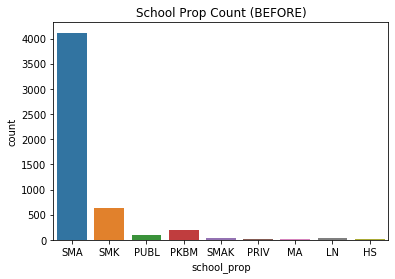

In [24]:
sns.countplot(OA_master['school_prop'])
plt.title('School Prop Count (BEFORE)')

##### Unite SMAK to SMA

In [25]:
smak_sch_name = OA_master[OA_master['school_prop']=='SMAK'].school_name.unique()

In [26]:
OA_master.loc[OA_master.school_name.isin(smak_sch_name), 'school_prop'] = 'SMA'

##### Unite PUBL category

In [27]:
publ_sch_name = OA_master[OA_master['school_prop']=='PUBL'].school_name.unique()
publ_to_misc = ['SEKOLAH INDONESIA KUALA LUMPUR', 'SMK RK BINTANG TIMUR P.SIANTAR']
publ_to_SMA = [sch for sch in publ_sch_name if sch not in publ_to_misc]

In [28]:
OA_master.loc[OA_master.school_name.isin(publ_to_SMA), 'school_prop'] = 'SMA'
OA_master.loc[OA_master.school_name=='SEKOLAH INDONESIA KUALA LUMPUR', 'school_prop'] = 'LN'
OA_master.loc[OA_master.school_name=='SMK RK BINTANG TIMUR P.SIANTAR', 'school_prop'] = 'SMK'

##### Unite PRIV category

In [29]:
priv_sch_name = OA_master[OA_master['school_prop']=='PRIV'].school_name.unique()
priv_to_misc = ['SMK Bakti, Pangkalpinang', 'NEW ZEALAND INT SCH']
priv_to_SMA = [sch for sch in priv_sch_name if sch not in priv_to_misc]

In [30]:
OA_master.loc[OA_master.school_name.isin(priv_to_SMA), 'school_prop'] = 'SMA'
OA_master.loc[OA_master.school_name=='NEW ZEALAND INT SCH', 'school_prop'] = 'LN'
OA_master.loc[OA_master.school_name=='SMK Bakti, Pangkalpinang', 'school_prop'] = 'SMK'

Text(0.5, 1.0, 'School Prop Count (AFTER)')

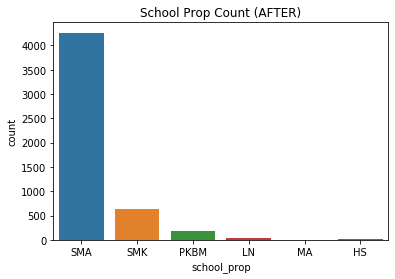

In [31]:
sns.countplot(OA_master['school_prop'])
plt.title('School Prop Count (AFTER)')

## School State Grouping
- Impute ' ' states
- Grouping States to Geographical Units

In [32]:
#syncing LN school name in school_prop and school_state
LN_sch_name = OA_master[OA_master['school_prop']=='LN'].school_name.unique()

OA_master.loc[OA_master.school_name.isin(LN_sch_name), 'school_state'] = 'LN'

##### Handling ' ' states

In [33]:
OA_master[OA_master['school_state']==' '].school_name.unique()

array(['SMA Negeri 8 Surakarta', 'SMAN 1, SIBOLGA', 'SMA YAD Sukabumi',
       'SMA Malidar', 'SMA Djuwita Kalideres', 'PKBM CAHAYA BANGSA',
       'SMAN 2 Purwodadi Grobogan', 'SMAK ANALISIS KIMIA',
       'PKBM BANYUANYAR', 'SMA Muhammadiyah 1',
       'SMK Bakti, Pangkalpinang', 'PKBM Negeri Kebon Jeruk',
       'SMA Negeri 1 jailolo', 'SMA Negeri 1 Tualang', 'SMAN 1, Cianjur',
       'PKBM PANBI', 'SMA Seminari St.Berkhmans Toda',
       'SMK NEGERI I TROWULAN', 'SMK PGRI Subang', 'SMK PGRI 4 NGAWI',
       'SMA Negeri 4, Medan', 'SMAN 15 Jakarta Utara', 'SMAN 2 Riau',
       'SMK Negeri 7 Samarinda', 'SMAN 1 Bangil', 'SMA KRISTEN SHEKINAH'],
      dtype=object)

In [34]:
#create dictionary between school_name and possible school state
dict_sch_state = {
    'DKIJKT': ['SMA Djuwita Kalideres', 'PKBM CAHAYA BANGSA', 'Disciples For Christ Int. Sch', 
                'PKBM Negeri Kebon Jeruk', 'PKBM PANBI', 'SMAN 15 Jakarta Utara'],
    'JATENG': ['SMA Negeri 8 Surakarta', 'SMAN 2 Purwodadi Grobogan', 'PKBM BANYUANYAR', 'SMA KRISTEN SHEKINAH'],
    'JABAR': ['SMA YAD Sukabumi', 'SMA Malidar', 'SMAK ANALISIS KIMIA', 'SMAN 1, Cianjur', 'SMK PGRI Subang'],
    'JATIM': ['SMK NEGERI I TROWULAN', 'SMK PGRI 4 NGAWI', 'SMAN 1 Bangil'],
    'SUMUT': ['SMAN 1, SIBOLGA', 'SMA Negeri 4, Medan'],
    'DIY': ['SMA Muhammadiyah 1'],
    'BANGKA': ['SMK Bakti, Pangkalpinang'],
    'MALUTA': ['SMA Negeri 1 jailolo'],
    'RIAU': ['SMA Negeri 1 Tualang', 'SMAN 2 Riau'],
    'NTT': ['SMA Seminari St.Berkhmans Toda'],
    'KALTIM': ['SMK Negeri 7 Samarinda']
}

In [35]:
#impute ' ' state based on school_name
for state, sch_name in dict_sch_state.items():
    OA_master.loc[OA_master.school_name.isin(sch_name), 'school_state'] = state

In [36]:
#check if any ' ' states left
len(OA_master[OA_master['school_state']==' '])

0

##### Grouping States to Geo Units

In [37]:
OA_master.school_state.unique()

array(['SUMUT', 'SUMBAR', 'DIY', 'JATENG', 'DKIJKT', 'JABAR', nan, 'ACEH',
       'MALUKU', 'LAMPUN', 'JATIM', 'NTT', 'SUMSEL', 'RIAU', 'BANTEN',
       'BALI', 'KALBAR', 'KALTGH', 'SULSEL', 'KALSEL', 'KALUT', 'SULBAR',
       'SULUT', 'GORONT', 'NTB', 'PAPUA', 'LN', 'BENGKU', 'SULTGH',
       'JAMBI', 'MALUTA', 'KALTIM', 'BANGKA', 'PAPBRT', 'PEKANB',
       'SULTGR'], dtype=object)

In [38]:
dict_reg = {
    'JAV': ['DIY', 'DKIJKT', 'BANTEN', 'JATENG',  'JABAR', 'JATIM'],
    'SUM': ['SUMUT', 'SUMBAR', 'ACEH', 'LAMPUN', 'SUMSEL', 'RIAU', 'BENGKU', 'JAMBI', 'BANGKA', 'PEKANB'],
    'KAL': ['KALBAR', 'KALTGH', 'KALSEL', 'KALUT', 'KALTIM'],
    'SUL': ['SULSEL', 'SULBAR', 'SULUT', 'SULTGH', 'SULTGR', 'GORONT'],
    'SUN': ['NTT', 'NTB', 'BALI'],
    'MAL': ['MALUKU', 'MALUTA'],
    'PAP': ['PAPBRT', 'PAPUA'],
    'LN': ['LN']
}

In [39]:
OA_master['school_geo_unit'] = None

for geo_unit, state in dict_reg.items():
    OA_master.loc[OA_master.school_state.isin(state), 'school_geo_unit'] = geo_unit

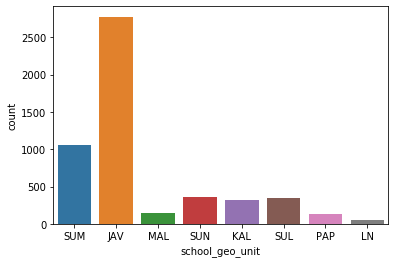

In [40]:
sns.countplot(OA_master.school_geo_unit)

In [41]:
rearr_cols = [
    'form_number',
    'major_code_oa',
    'major_name_oa',
    'gender',
    'school_prop',
    'school_name',
    'school_state',
    'school_geo_unit',
    'curriculum_name'
]

In [42]:
OA_master = OA_master[rearr_cols]

In [43]:
OA_master.head()

,form_number,major_code_oa,major_name_oa,gender,school_prop,school_name,school_state,school_geo_unit,curriculum_name
0,1811200001,01011,Manajemen,Female,SMA,SMA Negeri 1 Silima Pungga,SUMUT,SUM,Other
1,1811200002,02022,Arsitektur,Male,SMA,SMA Don Bosco Padang,SUMBAR,SUM,International Baccaularate New
2,1811200003,02023,Desain Komunikasi Visual,Female,SMA,SMA Negeri 5 Yogyakarta,DIY,JAV,International Baccaularate New
3,1811100004,02025,Desain Produk,Male,SMA,SMA Don Bosco Padang,SUMBAR,SUM,International Baccaularate New
4,1811100122,06061,Seni Musik,Female,SMA,SMA Negeri 1 Klaten,JATENG,JAV,Science


# Dump to Pickle

In [44]:
dump_to_pickle(OA_master, out_path)